<a href="https://colab.research.google.com/github/dsliwka/EEMP2023/blob/main/SalesSimDiDSampleSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
!pip install Stargazer
from stargazer.stargazer import Stargazer

**Generating Simulated Panel Data**

----

In [7]:
n=500
df1=pd.DataFrame(index=range(n))
df1['ability']=np.random.normal(100,15,n)
df1['year']=1

## This is a numer identifying each person in the data set
df1['persnr']=df1.index

## Determine who will be (later) trained
df1['tgroup']=(df1.ability+np.random.normal(0,10,n)>=100)*1

## Copy the DataFrame to create second year observations stored in df2
df2=df1.copy()
df2['year']=2

## Training only in the training group and only in year 2:
df1['training']=0
df2['training']=df2.tgroup

## Generate DataFrame that spans both years combining the two:
## Note for each person we have two rows, one for each year
df=pd.concat([df1,df2], sort=False)

## Generate sales as before
## but add a year effect: sales increase by 4000 Euro between years 1 and 2:
df['sales']= 10000 + df.training*5000 + df.ability*100 + df.year*4000    + np.random.normal(0,4000,2*n)


**Looking at the Diff-in-Diff**

----

<Axes: xlabel='year', ylabel='sales'>

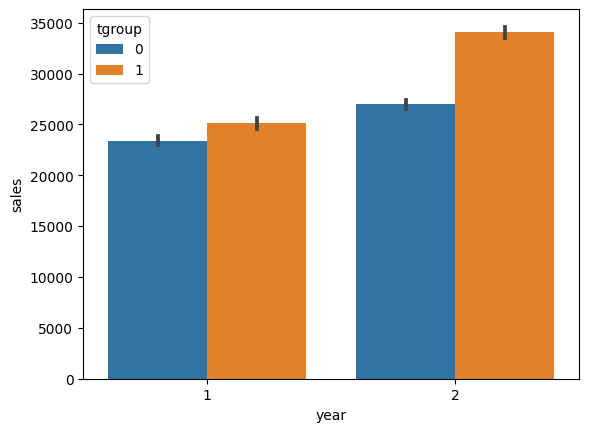

In [8]:
sns.barplot(x='year', y='sales', hue='tgroup', data=df)

In [9]:
df.groupby(['tgroup','year']).sales.mean()

tgroup  year
0       1       23389.719472
        2       26974.737398
1       1       25099.291969
        2       34047.073232
Name: sales, dtype: float64

**Note:**

You can compute the diff-in-diff manually from this table or compute the means in the subgroups as follows (there are many alternative ways to do this in Python).

In [10]:
df[(df.tgroup==1) & (df.year==2)].sales.mean()-df[(df.tgroup==0) & (df.year==2)].sales.mean() -(df[(df.tgroup==1) & (df.year==1)].sales.mean()-df[(df.tgroup==0) & (df.year==1)].sales.mean())

5362.76333581144

**Regression Diff-in-Diff**

----

In [11]:
df['post']=(df.year==2)*1
reg1=smf.ols('sales ~ tgroup*post', data=df).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     298.1
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          4.59e-138
Time:                        14:27:36   Log-Likelihood:                -9757.2
No. Observations:                1000   AIC:                         1.952e+04
Df Residuals:                     996   BIC:                         1.954e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.339e+04    254.481     91.911      

**Interpretation**

Here we estimate the Diff-in-Diff trough a regression where troup estimates the difference in levels in year 1, post estimates the time trend (the increase in sales in the "control group" where tgroup=0) and the interaction term estimates the difference in the change over time between the "treatment group" and the "control group".

We thus get the same estimate for the causal effect as in our "manual" analysis above, but conveniently, we here also get an estimate of the standard error.

**Estimating a Fixed Effects Model**

----

As a first step, we can estimate the model by OLS using Statsmodels. We just have to add dummy variables for all years and all agents. We can do so by adding these categorial variables with the + C() operator in Statsmodels. Note that estimating this takes a while and the table shows a long list of all the estimated fixed effects.

In [22]:
regFE=smf.ols('sales ~ training + C(year) + C(persnr)', data=df).fit()
Stargazer([regFE])


To avoid the long table you can use covariate_order in Stargazer. Note that only covariates in the list are displayed in the table. The others are not shown (even though they are part of the estimates). Here I only display training and the year dummy for year 2:

In [ ]:
regFE=smf.ols('sales ~ training + C(year) + C(persnr)', data=df).fit()
tab=Stargazer([regFE])
tab.covariate_order(["training","C(year)[T.2]"])
tab

Typically, we would rather use a specific method to estimate fixed effects models. In Python such a method is implemented in the package Linearmodels which we have to install first:

In [23]:
!pip install linearmodels
from linearmodels import PanelOLS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 6.3 MB/s eta 0:00:00


To then estimate the model we first have to create a Multindex DataFrame where the first index characterizes the person ("entity") and the second the time. Then we can run the PanelOLS method. Importantly, don't forget to add the keywords "+ EntityEffects + TimeEffects" in the string where you specify your model.  

Note: The syntax in Linearmodels is slightly different than that of Statsmodels. One difference is that it returns an object that can directly be printed.

Unfortunately, Stargazer does not work with Linearmodels.

In [24]:
dfp=df.set_index(['persnr','year'])
regP=PanelOLS.from_formula('sales ~ training + EntityEffects + TimeEffects', data=dfp).fit()
print(regP)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  sales   R-squared:                        0.1885
Estimator:                   PanelOLS   R-squared (Between):              0.0920
No. Observations:                1000   R-squared (Within):               0.4139
Date:                Tue, Nov 07 2023   R-squared (Overall):              0.0997
Time:                        14:42:04   Log-likelihood                   -9346.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      115.70
Entities:                         500   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(1,498)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             115.70
                            